# User based and Item Based collaborative filtering

**Objective: To compare user based and item based collaborative filtering based recommenders**

In [1]:
#Import the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import random
import zipfile

## Getting the dataset

In [2]:
#Getting the dataset
dataset_urls=[
    'http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip',
    'http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip',
    'http://files.grouplens.org/datasets/hetrec2011/hetrec2011-delicious-2k.zip'
]

dataset_url=dataset_urls[0]
dataset_name=dataset_url[dataset_url.rfind('/')+1:]

# Download the dataset
import requests
r = requests.get(dataset_url, allow_redirects=True)
open(dataset_name, 'wb').write(r.content)

18856822

## Reading the target file in pandas

In [3]:
# inspect the files in the dataset
print('Files in ', dataset_name)
with zipfile.ZipFile(dataset_name) as z:
    for name in z.namelist():
        print(name)
print()

# We use the file that contains user, items, and their ratings
target_file='user_ratedmovies-timestamps.dat'
print('Initial content in ', target_file)
with zipfile.ZipFile(dataset_name) as z:
   with z.open(target_file) as f:
      data = pd.read_csv(f, header=0, delimiter="\t")
      print(data.head())    

Files in  hetrec2011-movielens-2k-v2.zip
user_taggedmovies-timestamps.dat
movie_actors.dat
movie_countries.dat
movie_directors.dat
movie_genres.dat
movie_locations.dat
movie_tags.dat
movies.dat
readme.txt
tags.dat
user_ratedmovies.dat
user_ratedmovies-timestamps.dat
user_taggedmovies.dat

Initial content in  user_ratedmovies-timestamps.dat
   userID  movieID  rating      timestamp
0      75        3     1.0  1162160236000
1      75       32     4.5  1162160624000
2      75      110     4.0  1162161008000
3      75      160     2.0  1162160212000
4      75      163     4.0  1162160970000


## Basic Data stats

In [4]:
nusers = data.userID.nunique()
nitems = data.movieID.nunique()
print(f'Number of users : {nusers}')
print(f'Number of movies : {nitems}')
print(f'Highest rating: {max(data.rating)} ,Lowest rating: {min(data.rating)}')
print(f'Number of ratings : {len(data.rating)}')

density = len(data.rating)/(nusers*nitems)
sparsity = 1 - density
print(f'Density: {density}')
print(f'Sparsity: {sparsity}')

Number of users : 2113
Number of movies : 10109
Highest rating: 5.0 ,Lowest rating: 0.5
Number of ratings : 855598
Density: 0.040055491685820954
Sparsity: 0.9599445083141791


**96 % of the data is sparse**

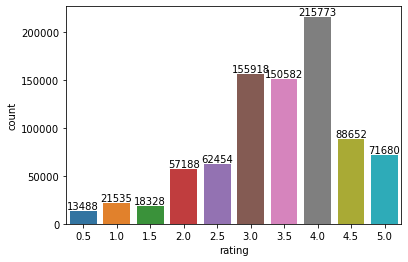

In [5]:
#barplot of rating values

ax = sns.countplot(x = data.rating)
for container in ax.containers:
    ax.bar_label(container)

**4.0 is the most common rating by the users to the movies**

<AxesSubplot:ylabel='Count'>

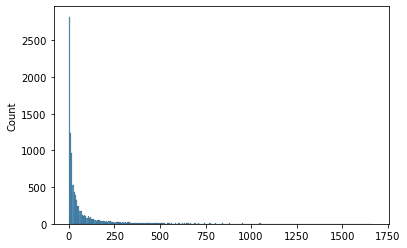

In [6]:
#Checking long tails for movies
movie_counts = data.groupby('movieID')['movieID'].count().values
sns.histplot(movie_counts)

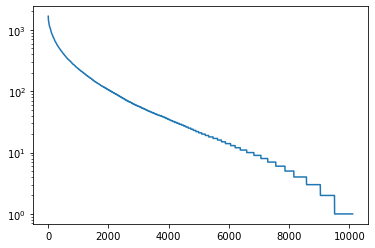

In [7]:
#movie distribution on log scale

plt.plot(sorted(movie_counts,reverse = True))
plt.yscale('log')
plt.show()

<AxesSubplot:ylabel='Count'>

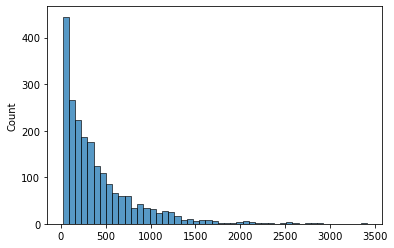

In [8]:
#checking long tail for users
user_counts = data.groupby('userID')['userID'].count().values
sns.histplot(user_counts)

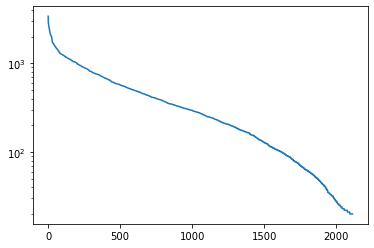

In [9]:
#user distribution on log scale
plt.plot(sorted(user_counts,reverse = True))
plt.yscale('log')
plt.show()

# Item based similarties

## Reading the movies data

In [10]:
target_file='movies.dat'
print('Initial content in ', target_file)
with zipfile.ZipFile(dataset_name) as z:
   with z.open(target_file) as f:
      movies = pd.read_csv(f, header=0, delimiter="\t",encoding = 'ISO-8859-1')
    
movies.head()  # print the first 5 rows

Initial content in  movies.dat


,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,...,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,...,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...


In [11]:
#joining the ratings data with movies to get the movie names
data2 = data.merge(movies,how = 'left',left_on = 'movieID', right_on = 'id')

In [12]:
#Final ratings data with movie names
ratings = data2[['userID','movieID','rating','title']]

## Splitting the data for future evaluation

In [13]:
random.seed(1)

ratio=0.8 # 80% of the data is kept in training
mask = np.random.rand(len(ratings)) < ratio
train_ratings = ratings[mask]
test_ratings = ratings[~mask]

pd.to_pickle(train_ratings, 'train_df', protocol=4)
pd.to_pickle(test_ratings, 'test_df', protocol=4)

In [14]:
#Loading the whole data from pickle files
train_ratings = pd.read_pickle('train_df')
test_ratings = pd.read_pickle('test_df')

print(f'Total:{len(ratings)}, Train: {len(train_ratings)},Test:{len(test_ratings)}')

Total:855598, Train: 683989,Test:171609


In [15]:
#check if every user which is in test data is also in training

set(test_ratings['userID']).difference(set(train_ratings['userID']))

set()

In [16]:
#check if every movie which is in test data is also in training

len(set(test_ratings['movieID']).difference(set(train_ratings['movieID'])))

130

In [17]:
#these movies should not be considered when evaluting the recommender
excluded_movies = set(test_ratings['movieID']).difference(set(train_ratings['movieID']))

In [18]:
#Utility matrix for item based similarities (movies in rows and users in columns)

def create_X_items(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['movieID'].nunique()
    N = df['userID'].nunique()

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieID"]), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userID"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieID"])))
    movie_name_mapper = dict(zip(ratings['movieID'],ratings['title']))

    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [movie_mapper[i] for i in df['movieID']]

    X = csr_matrix((df["rating"], (item_index,user_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper,movie_name_mapper

X_items, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper,movie_name_mapper = create_X_items(train_ratings)


In [19]:
#computing the items cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

item_cos_sim = cosine_similarity(X_items)

In [20]:
#item_cos_sim[2316,1083]

# User based similarities

In [21]:
#Utility matrix for user based similarities (users in rows and items in columns)

def create_X_users(df):
    """
    Generates a sparse matrix from ratings dataframe. (Users * Items)

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userID'].nunique()
    N = df['movieID'].nunique()

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieID"]), list(range(N))))
    movie_name_mapper = dict(zip(ratings['movieID'],ratings['title']))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userID"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieID"])))

    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [movie_mapper[i] for i in df['movieID']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper,movie_name_mapper

X_users, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper,movie_name_mapper = create_X_users(train_ratings)

In [22]:
user_cos_sim = cosine_similarity(X_users)

In [23]:
#user_cos_sim[432,668]

## Computing item based recommendations

In [24]:
def candidate_items_for_user(data, user):
    """
    Returns the candidate movies which can be recommended to a uset

    Args:
        data: train ratings data (pandas dataframe)

    Returns:
        a set of candidate movie id's
    """
    all_movies = set(data['movieID'].unique())
    user_movies = set(data[data['userID'] == user]['movieID'].unique())
    cand_items = all_movies.difference(user_movies)
    return set(cand_items)

In [26]:
def itembased_recommender(train_df,user):
    """
    Generates a dictionary with movies as keys and predicted ratings a values for a user (sorted by values in desc)

    Args:
        train_df: training ratings data (pandas dataframe)
        user: userid (int)

    Returns:
        A dictionary of movies, predicting ratings sorted by predicted ratings
    """
    cand_items = candidate_items_for_user(train_df,user)
    cand_scores = {}
    
    for cand in cand_items:
        score = 0
        den = 0
        sims = []
        
        user_df = train_df[train_df['userID'] == user]
        user_train_movies = user_df['movieID']
        user_train_ratings = user_df['rating']
        
        for movieid in user_train_movies:
            movie_index = movie_mapper[movieid]
            cand_movie_index = movie_mapper[cand]
            
            sim = item_cos_sim[movie_index,cand_movie_index]
            sims.append(sim)

        score += np.array(user_train_ratings)@np.array(sims)
        den += np.sum(sims)
        if den == 0:
            score = 0
        else:
            score = score/den

        cand_scores[cand] = score
        
    return dict(sorted(cand_scores.items(),key = lambda cand_scores:cand_scores[1],reverse = True))

In [27]:
#generate predicted ratings for a user based in item based collaborative filtering
import time
t0 = time.time()
itembased_recommender(train_ratings,75)
print(time.time()-t0)

7.997180938720703


In [28]:
#top 10 recommendations for a user
for i,movieid in enumerate(itembased_recommender(train_ratings,75)):
    if i <=9:
        print(i,movie_name_mapper[movieid])

0 Earth: Final Conflict
1 We're Not Married!
2 Asfour Stah
3 A Little Bit of Soul
4 Tout près des étoiles: Les danseurs de l'Opéra de Paris
5 Naturally Native
6 Le bossu
7 I, Madman
8 Milk and Honey
9 Two Men Went to War


In [29]:
test_users = list(test_ratings['userID'].unique())
test_users = [75]

abs_error = 0
sq_error = 0
n = 0

for user in test_users:
    user_pred_ratings = itembased_recommender(train_ratings,user)
    test_user_data = test_ratings[test_ratings['userID'] == user]
    for index,row in test_user_data.iterrows():
        m_id = row['movieID']
        pred_rating = user_pred_ratings[m_id]
        act_rating = row['rating']
        abs_error += np.abs(pred_rating - act_rating)
        sq_error += abs_error**2
        n += 1
mae = abs_error/n
rmse = np.sqrt(sq_error/n)

In [30]:
mae,rmse

(0.6188689426742401, 2.2844922939295955)

## User based recommender

In [31]:
def userbased_score(data, user, candidate,neighbours):
    """
    Computes the weighted rating for a candiate item based on neighbours similarity.
    
    Args:
        data: training ratings data (pandas dataframe)
        user: userid (int)
        candidate: candidate movieid (int)
        neighbours: nearest neighbours based on similarity (list)

    Returns:
        A dictionary of movies, predicting ratings sorted by predicted ratings
    """
    score = 0
    sims = 0
    rows = data[data['movieID'] == candidate]
    #check if the candidate item is rated by atleast 2 neighbour users. If we don't apply a cutoff then weighted rating
    #will be same as the neighbor which does not make much sense. This cutoff can be hyperparamter too
    if (pd.Series(rows['userID'].unique()).isin(neighbours).sum()) >= 2:
        
        for neighbour in neighbours:
            
            rows = data[(data['userID'] == neighbour) & (data['movieID'] == candidate)]
            
            if len(rows) > 0:
                sim = user_cos_sim[user_mapper[neighbour],user_mapper[user]]
                rating = rows['rating'].iloc[0]
                score += sim*rating
                sims += sim
                
    return 0.0 if sims == 0 else score/sims

In [32]:
def userbased_recommender(data,user,k_neigbours):
    """
    Generates a dictionary with movies as keys and predicted ratings a values for a user (sorted by values in desc)

    Args:
        data: training ratings data (pandas dataframe)
        user: userid (int)
        k_neighbours: Number of neighbours to be considered similar to the user (int)

    Returns:
        A dictionary of movies, predicting ratings sorted by predicted ratings
    """
    cand_items = candidate_items_for_user(data,user)
    cand_scores = {}
    
    #getting the k neareset users based on similarities. The k could be a hyperparamter
    user_sims = {}
    for u in list(data['userID'].unique()):
        if u == user:
            continue
        sim = user_cos_sim[user_mapper[u],user_mapper[user]]
        user_sims[u] = sim
        
    neighbours = list(dict(sorted(user_sims.items(),key = lambda user_sims:user_sims[1],reverse = True)[:k_neigbours]).keys())
    
    for cand in cand_items:
        score = userbased_score(data, user, cand,neighbours)
        cand_scores[cand] = score
    return dict(sorted(cand_scores.items(),key = lambda cand_scores:cand_scores[1],reverse = True))


In [33]:
#generate predicted ratings for a user based in user based collaborative filtering
import time
t0 = time.time()
userbased_recommender(train_ratings,75,10)
print(time.time()-t0)

16.11081099510193


In [34]:
#top 10 recommendations for a user
for i,movieid in enumerate(userbased_recommender(train_ratings,75,10)):
    if i <=9:
        print(i,movie_name_mapper[movieid])

0 Interview with the Vampire: The Vampire Chronicles
1 Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan
2 Crash
3 The Matrix
4 Zatôichi
5 Léon
6 Requiem for a Dream
7 Lock, Stock and Two Smoking Barrels
8 300
9 Fight Club


## Evaluating the recommender

In [38]:
def evaluate_recommender(train_df,test_df,recommender_type):
    """
    Generates the MAE and RMSE score for the recommender type

    Args:
        train_df: training ratings data (pandas dataframe)
        test_df: testing ratings data (pandas dataframe)
        recommender_type: type of collaborative filtering recommender (userbased or itembased)
    Returns:
        MAE and RMSE score (tuple)
    """
    test_df = test_df[~test_df['movieID'].isin(excluded_movies)]      #exclude the excluded movies
    test_users = list(test_df['userID'].unique())

    abs_err = 0
    sq_err = 0
    n = 0

    for userid in test_users:
        if recommender_type == 'itembased':
            user_pred_ratings_dic = itembased_recommender(train_df,userid)
        elif recommender_type == 'userbased':
            user_pred_ratings_dic = userbased_recommender(train_df,userid,10)
        else:
            print("Please check the recommender type")
        user_test_df = test_df[test_df['userID'] == userid]
        user_test_movies = list(user_test_df['movieID'])
        user_actual_ratings = np.array(user_test_df[user_test_df['movieID'] == user_test_movies]['rating'])
        
        user_pred_ratings = np.array([user_pred_ratings_dic[x] for x in user_test_movies])
        
        abs_err += np.sum(np.abs(np.subtract(user_actual_ratings,user_pred_ratings)))
        sq_err += np.sum(np.subtract(user_actual_ratings,user_pred_ratings)**2)
        n += len(user_actual_ratings)

    mae = abs_err/n
    rmse = np.sqrt(sq_err/n)
    return mae, rmse

In [39]:
#evaluating the item based collaborative filtering recommender
item_mae,item_rmse = evaluate_recommender(train_ratings,test_ratings,'itembased')
print(f'MAE:{round(item_mae,3)},RMSE:{round(item_rmse,3)}')

MAE:0.691,RMSE:0.902


In [42]:
#evaluating the user based collaborative filtering recommender
user_mae,user_rmse = evaluate_recommender(train_ratings,test_ratings,'userbased')
print(f'MAE:{round(user_mae,3)},RMSE:{round(user_rmse,3)}')

MAE:1.346,RMSE:1.897


**1. Item based collaborative fitering has lower RMSE than the User based collaborative Filtering**

**2. The results depend on the hypemarameters like number of nearest neighbours and the type of similarity function**

**3. These results should not be used to derive the insights on which recommender is better. Online AB testing should be done to compare the recommenders**